The purpose of this notebook is to show how to **calibrate and integrate** XRD data using pyFAI library.

See pyFAI tutorial here: (https://www.youtube.com/watch?v=j0cphX3z2mM&ab_channel=ESRFsynchrotron)
See pyFAI documents here: (https://pyfai.readthedocs.io/en/stable/)

At 28ID-2-D-tomo beamline endstation of NSLS-II, we mainly use two different area detectors:

* PerkinElmer : https://resources.perkinelmer.com/corporate/pdfs/downloads/bro_digitalxraydetectors.pdf
* Dexela 2923 : https://www.sciencedirect.com/science/article/pii/S0168900212006730



# general imports

In [ ]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy
import time

import numpy as np
import xarray as xr


from IPython.display import clear_output


In [ ]:
# We need import pyFAI,PyQt5,ipympl packages (if not available pip-install)
try:
    import ipympl
except:
    !!pip install ipympl
    import ipympl

# if running on google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

try:
    import PyQt5
except:
    !!pip install PyQt5

try:
    import pyFAI
except:
    !!pip install pyfai
    import pyFAI

In [ ]:
%matplotlib widget

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# setting up the example data path

In [ ]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace example_data_path with the path the notebook and its data folder are stored on

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
    from google.colab import output
    output.enable_custom_widget_manager()

except:
    pass

In [ ]:
# Assuming notebook and data folder are here.

here = os.getcwd()
example_data_path = 'example_data/tutorial/pyFAI'

os.chdir('%s/%s'%(here,example_data_path))
os.listdir()

# Re-calibration of a diffraction image with Jupyter

In [ ]:
# from_PerkinElmer_detector folder has calibration.poni file with content below:
%cat from_PerkinElmer_detector/calibration.poni

In [ ]:
# Create a "normal" azimuthal integrator from provided calibration poni file
ai_provided = pyFAI.load('from_PerkinElmer_detector/calibration.poni')
ai_provided

\
Here we will re-calibrate the detector geometry by following pyFAI tutorials \

* https://pyfai.readthedocs.io/en/latest/usage/tutorial/Recalib/Recalib_notebook.html
* https://www.silx.org/doc/pyFAI/latest/usage/cookbook/calibration_with_jupyter.html



In [ ]:
from pyFAI.gui import jupyter
import fabio
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.gui.jupyter.calib import Calibration
from pyFAI.goniometer import SingleGeometry
print(f"Using pyFAI version: {pyFAI.version}")
start_time = time.perf_counter()

In [ ]:
# this loads a tiff file using fabio package that is installed by pyFAI
img = fabio.open("from_PerkinElmer_detector/LaB6.tiff").data

fig = plt.figure()
ax = fig.add_subplot()
jupyter.display(img,ax=ax);

In [ ]:
# Definition of the detector and of the calibrant:
detector  = pyFAI.detector_factory("Perkin Elmer")
calibrant = CALIBRANT_FACTORY("LaB6")
calibrant.wavelength = 0.1814*1e-10 # wavelength is usually provided by the beamline scientist

calib = Calibration(img, calibrant=calibrant, wavelength=calibrant.wavelength, detector=detector)

# 1. Set the ring number (0-based value), below the plot
# 2. Pick the ring by right-clicking with the mouse on the image.
# 3. Restart at 1. for at least a second ring
# 4. Click refine to launch the calibration.

In [ ]:
# This is the calibrated geometry:

%matplotlib inline

gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

In [ ]:
# re-extract all control points using the "massif" algorithm
calib.extract_cpt()

In [ ]:
# This is the geometry with all rings defined:
gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

In [ ]:
# Create a azimuthal integrator (without fitting capabilities from the geometry-refinement object)
ai_recalibrated = pyFAI.load(gr)
ai_recalibrated

In [ ]:
# Display the integrated data to validate the calibration.
# Note that calibration with provided (from_PerkinElmer_detector/calibration.poni)
# is almost same as the re-calibrated one. Therefore, blue and orange is very similar.

from matplotlib.pyplot import subplots
fig, ax = subplots(1, 1, figsize=(10, 5), dpi=128)
jupyter.plot1d(ai_provided.integrate1d(img, npt=5000, unit='2th_deg', method='bbox'),
               calibrant=calibrant, ax=ax, label='with provided calibration')

jupyter.plot1d(ai_recalibrated.integrate1d(img, npt=5000, unit='2th_deg', method='bbox'),
               calibrant=calibrant, ax=ax, label='re-calibrated')

ax.set_xlim([1,16])
ax.set_ylim(bottom=8)
ax.set_yscale('log')

In [ ]:
# as expected, the difference between ai_provided and ai_recalibrated is small
print(ai_provided)
print('\n\n')
print(ai_recalibrated)

# Integrating images with azimuthal integrator (ai) object

In [ ]:
# As explained in the previous section, we can read ai through a provided poni file or generate it by performing a calibration.
# A third option is to define it as in the following


ai_dict = {
    'detector_name':"Perkin Elmer",
    'wavelength':1.814000e-11,
    'detector_dist':1.4280177479893559,
    'detector_poni1':0.23398429857415295,
    'detector_poni2':0.37634908408057827,
    'detector_rot1':-0.003994332959290178,
    'detector_rot2':-0.026132616520970278,
    'detector_rot3':-4.71036871681453e-10,
    'ai_from':'20240122-191827_step_scan_uid=4d94f1ef__LaB6.nc'
}
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
ai = AzimuthalIntegrator(
    detector=ai_dict['detector_name'],
    wavelength=ai_dict['wavelength'],
    dist=ai_dict['detector_dist'],
    poni1=ai_dict['detector_poni1'],
    poni2=ai_dict['detector_poni2'],
    rot1=ai_dict['detector_rot1'],
    rot2=ai_dict['detector_rot2'],
    rot3=ai_dict['detector_rot3'],
)

ai

In [ ]:
# for LaB6
img = fabio.open("from_PerkinElmer_detector/LaB6.tiff").data
i2d = ai.integrate2d(img, npt_rad=5000, npt_azim=350, unit='2th_deg', method='bbox') # 2D integrated image (i.e. cake)
i1d = ai.integrate1d(img, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile
calibrant = CALIBRANT_FACTORY("LaB6")
calibrant.wavelength = ai.wavelength


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
jupyter.display(img,ax=ax);
ax.set_title('LaB6 raw image')
ax = fig.add_subplot(1,3,2)
jupyter.plot2d(i2d,ax=ax);
ax = fig.add_subplot(1,3,3)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);



# for CeO2
img = fabio.open("from_PerkinElmer_detector/CeO2.tiff").data
i2d = ai.integrate2d(img, npt_rad=5000, npt_azim=350, unit='2th_deg', method='bbox') # 2D integrated image (i.e. cake)
i1d = ai.integrate1d(img, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile
calibrant = CALIBRANT_FACTORY("CeO2")
calibrant.wavelength = ai.wavelength

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
jupyter.display(img,ax=ax);
ax.set_title('CeO2 raw image')
ax = fig.add_subplot(1,3,2)
jupyter.plot2d(i2d,ax=ax);
ax = fig.add_subplot(1,3,3)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);

# Applying mask for the integration.

In [ ]:
# If you look closely, there are some weird kings in the spectrum.
# They are coming from detector artefacts and beamstop and we need to mask them.

fig = plt.figure(figsize=(10,5))


ax = fig.add_subplot(1,2,1)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);
ax.set_yscale('log')
ax.set_ylim(bottom=10)
ax.annotate('??', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

ax = fig.add_subplot(1,2,2)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);
ax.set_yscale('log')
ax.set_xlim([14,16])
ax.set_ylim(bottom=10)
ax.annotate('??', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

plt.tight_layout()

In [ ]:
# You can create a mask by running "pyFAI-drawmask" utilty that comes with pyFAI.
# Below is a screenshot from that. Once mask is done, you can save it as edf and use as shown in next cell.

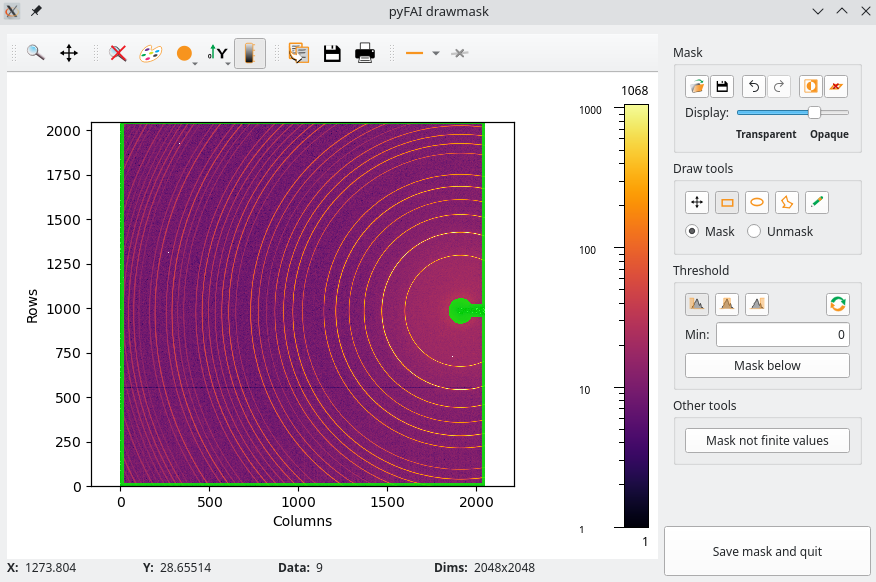
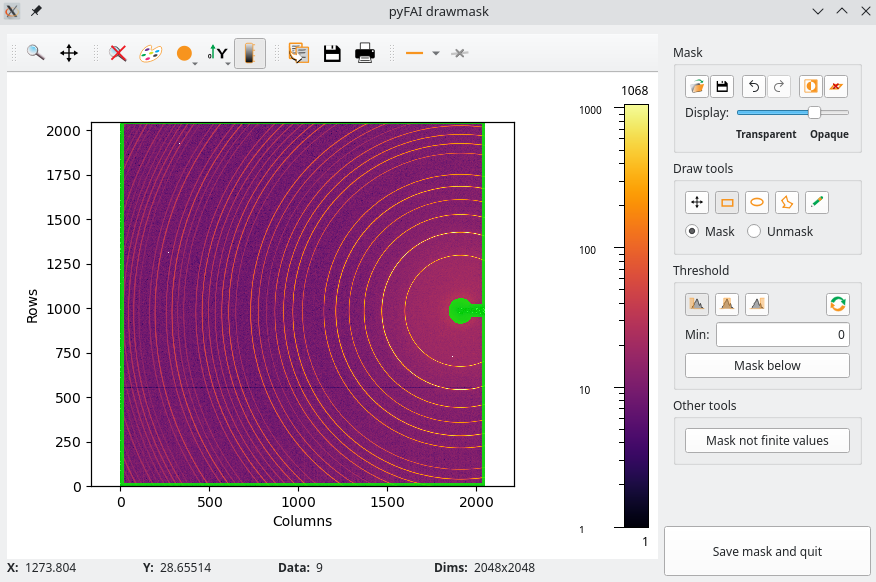

In [ ]:
# load mask
mask = fabio.open("from_PerkinElmer_detector/LaB6_mask.edf").data

# then use
i1d_with_mask = ai.integrate1d(img, mask=mask, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile


fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax,label='without mask');
jupyter.plot1d(i1d_with_mask,calibrant=calibrant,ax=ax,label='with mask');

ax.set_yscale('log')
ax.set_xlim([14,16])
ax.set_ylim(bottom=10)
ax.annotate('', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

plt.tight_layout()

# Exporting integrated 1d profile for subsequent analysis or plotting

In [ ]:
# Exporting is straightforward. You just need to add filename='xxx' to the integrator
i1d = ai.integrate1d(img, mask=mask,
                     npt=5000, filename = "from_PerkinElmer_detector/LaB6.xy",
                     unit='2th_deg', method='bbox')

In [ ]:
# on posix systems, we can see first 40 lines of the exported xy file
try:
    ! head -n 40 from_PerkinElmer_detector/LaB6.xy
except:
    pass

In [ ]:
# if we don't want header lines in the exported xy file, we can export it using np.savetxt as below.

out = np.column_stack( (i1d.radial, i1d.intensity) )
np.savetxt('from_PerkinElmer_detector/LaB6.xy',out,fmt=' %.4e  %.4e')

In [ ]:
# on posix systems, we can see first 40 lines of the exported xy file
try:
    ! head -n 40 from_PerkinElmer_detector/LaB6.xy
except:
    pass

In [ ]:
# there exist more options for ai.integrate1d.
# see docstring below

ai.integrate1d?

In [ ]:
# For example, if we want to limit radial range from 2 to 14 with 1200 points, we can do it like this:

i1d = ai.integrate1d(img, mask=mask, radial_range = (2,14),
                     npt=1200, filename = "from_PerkinElmer_detector/LaB6.xy",
                     unit='2th_deg', method='bbox')

data = np.loadtxt('from_PerkinElmer_detector/LaB6.xy',unpack=True)
plt.figure()
plt.plot(data[0],data[1])

# Applying median filter to remove bad pixels.

In [ ]:
# xarray's plotting tools will help us to see easier

%matplotlib inline

img = fabio.open("from_PerkinElmer_detector/CeO2.tiff").data

da = xr.DataArray(data=img,
                  coords=[np.arange(img.shape[0]),np.arange(img.shape[1])],
                  dims=['pixel_y', 'pixel_x'])

fig = plt.figure(dpi=96,figsize=(12,4))

ax = fig.add_subplot(1,3,1)
np.log(da).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,2)
np.log(da.sel(pixel_x=slice(1400,1525)).sel(pixel_y=slice(920,1100))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,3)
np.log(da.sel(pixel_x=slice(1720,1840)).sel(pixel_y=slice(0,120))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

In [ ]:
"""
find a way to get rid of these white spots in the image
"""

In [ ]:
img = scipy.ndimage.median_filter(img, size=3)
da = xr.DataArray(data=img,
                  coords=[np.arange(img.shape[0]),np.arange(img.shape[1])],
                  dims=['pixel_y', 'pixel_x'])

fig = plt.figure(dpi=96,figsize=(12,4))

ax = fig.add_subplot(1,3,1)
np.log(da).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,2)
np.log(da.sel(pixel_x=slice(1400,1525)).sel(pixel_y=slice(920,1100))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,3)
np.log(da.sel(pixel_x=slice(1720,1840)).sel(pixel_y=slice(0,120))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')